In [1]:
import ProbForecastFollmerProcess as pffp
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.distributions import MultivariateNormal
plt.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Computing on ' + str(device))

Computing on cuda


In [2]:
# reproducibility
SEED = 1024
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = True  
torch.manual_seed(SEED)  
np.random.seed(SEED)  
random.seed(SEED)

In [3]:
# defining number of dimensions
dim = 2

# defining base gaussian component
mean_0 = torch.tensor([5.0, 0.0], device = device)
cov_0 = torch.tensor([[1.5, 0.0], [0.0, 0.1]], device = device)

# defining number of mixture models
K = 5

# defining rotation angle
theta = torch.tensor([2.0*np.pi/K], device = device)

# defining rotation matrix
R_theta = lambda k: torch.tensor([[torch.cos(k*theta), -torch.sin(k*theta)], [torch.sin(k*theta), torch.cos(k*theta)]], device = device)
rotations = [R_theta(k) for k in range(K)]

# defining mixture
gmm_params = [{"mean": torch.matmul(R, mean_0), "cov": torch.matmul(torch.matmul(R, cov_0), R.T)} for R in rotations]
gmm_components = [MultivariateNormal(params["mean"], params["cov"]) for params in gmm_params]
print(gmm_params)

[{'mean': tensor([5., 0.], device='cuda:0'), 'cov': tensor([[1.5000, 0.0000],
        [0.0000, 0.1000]], device='cuda:0')}, {'mean': tensor([1.5451, 4.7553], device='cuda:0'), 'cov': tensor([[0.2337, 0.4114],
        [0.4114, 1.3663]], device='cuda:0')}, {'mean': tensor([-4.0451,  2.9389], device='cuda:0'), 'cov': tensor([[ 1.0163, -0.6657],
        [-0.6657,  0.5837]], device='cuda:0')}, {'mean': tensor([-4.0451, -2.9389], device='cuda:0'), 'cov': tensor([[1.0163, 0.6657],
        [0.6657, 0.5837]], device='cuda:0')}, {'mean': tensor([ 1.5451, -4.7553], device='cuda:0'), 'cov': tensor([[ 0.2337, -0.4114],
        [-0.4114,  1.3663]], device='cuda:0')}]


In [4]:
# settings of the simulation
delta_t = torch.tensor([1e-2], device = device)
observation_interval = 50

# defining number of observations and iterations
num_iters = int(1e5) 
num_observations = int(num_iters / observation_interval)

# rate of the poisson process
poisson_rate = torch.tensor([2.0], device = device)

# defining the configuration dictionary
simulation_conf = {
    "delta_t": delta_t,
    "observation_interval": observation_interval,
    "num_iters": num_iters,
    "num_observations": num_observations,
    "poisson_rate": poisson_rate,
    "gmm_components": gmm_components,
    "R_theta": R_theta,
    "K": K,
    "dim": dim,
    "device": device
}

# simulating the trajectory we will use for training
train_state_store, train_observation_store = pffp.utils.simulate_jump_diffusion(simulation_conf)
# moving train observation store to device 
train_observation_store = train_observation_store.to(device)

# simulating the trajectory we will use for testing
test_state_store, test_observation_store = pffp.utils.simulate_jump_diffusion(simulation_conf)
# moving test observation store to device 
train_observation_store = test_observation_store.to(device)

# printing shape of the data
print(f"{train_state_store.shape=}, {train_observation_store.shape=}")
print(f"{test_state_store.shape=}, {test_observation_store.shape=}")

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

train_state_store.shape=torch.Size([100000, 2]), train_observation_store.shape=torch.Size([2000, 2])
test_state_store.shape=torch.Size([100000, 2]), test_observation_store.shape=torch.Size([2000, 2])


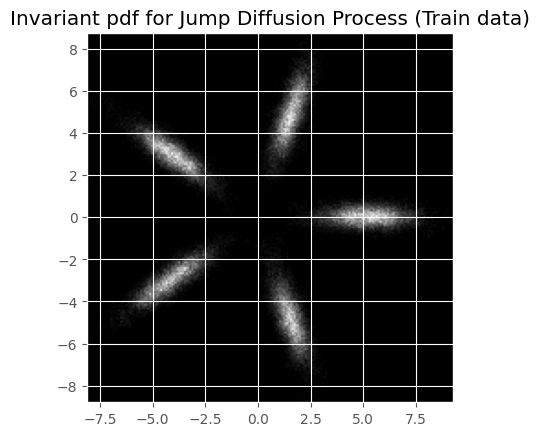

In [5]:
# defining figure and axes
fig, axes = plt.subplots()

# plotting the simulated dynamics
x = train_state_store[:,0].detach().cpu()
y = train_state_store[:,1].detach().cpu()
pffp.utils.plot_density(x, y, fig, axes, "Invariant pdf for Jump Diffusion Process (Train data)")

In [6]:
# defining lag
tau_mul = 1 # 3 4
# sampling function for training data
get_train_data = lambda N: pffp.utils.sample_observations(N, train_observation_store, tau_mul)
# sampling function for testing data
get_test_data = lambda N: pffp.utils.sample_observations(N, test_observation_store, tau_mul)

In [7]:
# defining data configurations
data = {    
    "train": get_train_data, 
    "test": get_train_data, 
}

# defining sampling configurations
sample = {
    "g": pffp.utils.g_follmer, 
    "N": 1000
}

# learning standardization means and standard deviations
standardization = {
    'state_mean': torch.mean(train_observation_store, 0).to(device), 
    'state_std': torch.std(train_observation_store, 0).to(device), 
}
print(standardization)

# defining network configurations
net_config = {
    "layers": [500]*5, 
    "standardization": standardization
}

# defining state configurations 
state = {
    "dim": dim
}

# defining optimization configurations
optim_config = {
    'minibatch': 1, 
    'num_obs_per_batch': 1000, 
    'num_iterations': 300,
    'learning_rate' : 0.001,
    'num_mc_samples': 100 
}

# defining model
model = pffp.core.model(data, sample, state, pffp.utils.interpolant, pffp.utils.velocity, net_config, device = "cuda")

# training model
model.train(optim_config)

{'state_mean': tensor([-0.1153, -0.0412], device='cuda:0'), 'state_std': tensor([3.6845, 3.6928], device='cuda:0')}
Optimization iteration: 1 Loss: 24.628210067749023
Optimization iteration: 50 Loss: 2.9276580810546875
Optimization iteration: 100 Loss: 2.3207106590270996
Optimization iteration: 150 Loss: 2.098907709121704
Optimization iteration: 200 Loss: 1.9425402879714966
Optimization iteration: 250 Loss: 1.8623595237731934
Optimization iteration: 300 Loss: 1.8690427541732788


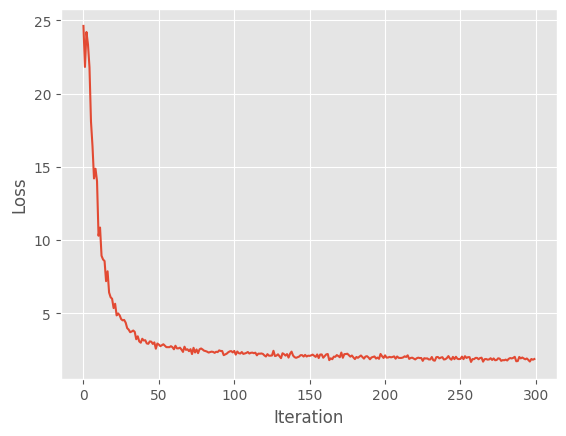

In [8]:
# plotting loss
losses = model.loss.detach().cpu()
fig, axes = plt.subplots()
axes.set_xlabel("Iteration")
axes.set_ylabel("Loss")
axes.plot(losses)

In [9]:
# sampling configuration
sample_config = {
    "minibatch": 1, 
    "num_obs_per_batch": 1000,
    "num_samples_per_obs": 100
}

# running sampling
(X0, X1), samples = model.sample(sample_config)
print(f"{X0.shape=}, {X1.shape=}, {samples.shape=}")

10 samples generated
20 samples generated
30 samples generated
40 samples generated
50 samples generated
60 samples generated
70 samples generated
80 samples generated
90 samples generated
100 samples generated
X0.shape=torch.Size([1000, 2]), X1.shape=torch.Size([1000, 2]), samples.shape=torch.Size([100, 1000, 2])


/tmp/ipykernel_31066/4036112061.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


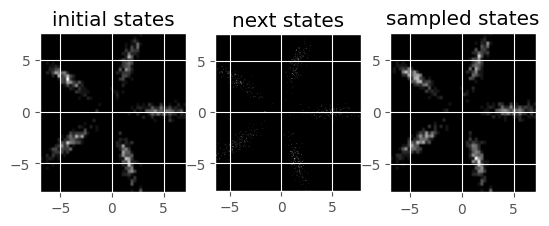

In [10]:
%matplotlib inline
# retrieving the data
x_hat, y_hat = samples[0, :, 0].detach().cpu(), samples[0, :, 1].detach().cpu()
x0, y0 = X0[:, 0].detach().cpu(), X0[:, 1].detach().cpu()
x1, y1 = X1[:, 0].detach().cpu(), X1[:, 1].detach().cpu()

# defining axes and figure
fig, axes = plt.subplots(1, 3)

# plotting the distributions
pffp.utils.plot_density(x0, y0, fig, axes[0], title = "initial states", bins = 50)
pffp.utils.plot_density(x1, y1, fig, axes[1], title = "next states")
pffp.utils.plot_density(x_hat, y_hat, fig, axes[2], title = "sampled states", bins = 50)
fig.show()

/tmp/ipykernel_31066/2633835960.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


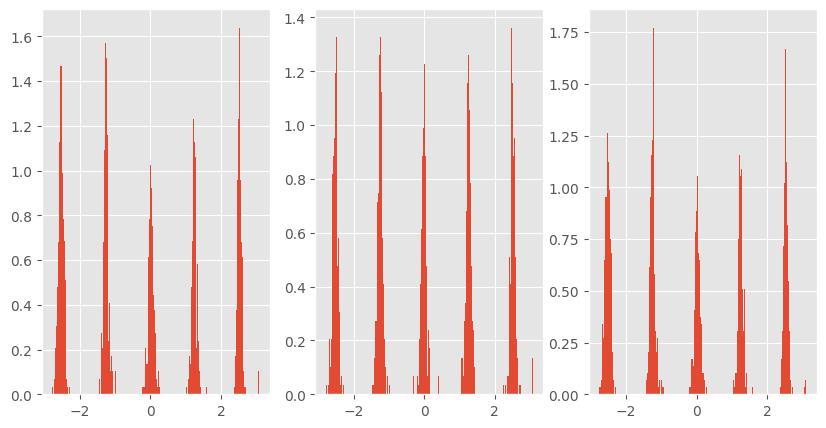

In [11]:
# converting to angular coordinates
theta_0 = pffp.utils.vec2angle(x0,y0)
theta_1 = pffp.utils.vec2angle(x1,y1)
theta_hat = pffp.utils.vec2angle(x_hat,y_hat)

# defining figure and axes
fig, axes = plt.subplots(1, 3, figsize = (10, 5))

# plotting the angular distributions
hist0 = axes[0].hist(theta_0, density = True, bins = 200)
hist1 = axes[1].hist(theta_1, density = True, bins = 200)
hist_hat = axes[2].hist(theta_hat, density = True, bins = 200)

# showing the figure
fig.show()